<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Required Libraries
!pip install transformers[torch] datasets accelerate
!pip install transformers seqeval[gpu]

In [ ]:
!pip install matplotlib

In [ ]:
from transformers import BertTokenizer, BertTokenizerFast
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel
import torch.optim as optim
import json
import ast
import random
from sklearn.metrics import accuracy_score
from torch import cuda
import re


maxlen=50

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
#maxlen=100
#batch_size=8

In [ ]:
"""
data =[
      {"text": "Urge X2 X85 X34 X80 X32 to have no common values", "labels": "[0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0]", "task_name": "token_classification"},
      {"text": "Urge X2 X85 X34 X80 X32 to have no common values", "labels": "[0]", "task_name": "sequence_classification"},
      {"text": "Reiterate the importance of uniqueness within X23 X11 X59 X81 X63 X58 X65 X66", "labels": "[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]", "task_name": "token_classification"},
      {"text": "Reiterate the importance of uniqueness within X23 X11 X59 X81 X63 X58 X65 X66", "labels": "[0]", "task_name": "sequence_classification"},
      {"text": "Express the necessity for distinct values within X73 X95 X85 X32 X28 X41", "labels": "[0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]", "task_name": "token_classification"},
      {"text": "Express the necessity for distinct values within X73 X95 X85 X32 X28 X41", "labels": "[0]", "task_name": "sequence_classification"}
]
"""

'\ndata =[\n      {"text": "Urge X2 X85 X34 X80 X32 to have no common values", "labels": "[0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0]", "task_name": "token_classification"},\n      {"text": "Urge X2 X85 X34 X80 X32 to have no common values", "labels": "[0]", "task_name": "sequence_classification"},\n      {"text": "Reiterate the importance of uniqueness within X23 X11 X59 X81 X63 X58 X65 X66", "labels": "[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]", "task_name": "token_classification"},\n      {"text": "Reiterate the importance of uniqueness within X23 X11 X59 X81 X63 X58 X65 X66", "labels": "[0]", "task_name": "sequence_classification"},\n      {"text": "Express the necessity for distinct values within X73 X95 X85 X32 X28 X41", "labels": "[0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]", "task_name": "token_classification"},\n      {"text": "Express the necessity for distinct values within X73 X95 X85 X32 X28 X41", "labels": "[0]", "task_name": "sequence_classification"}\n]\n'

In [ ]:


#filename = 'synthetic_data.txt'
#filename = 'synthetic_data_211123.txt'
#filename ='synthetic_data_211123_constraints_on_distances.txt'
#filename = 'synthetic_data_221123.txt'
filename='synthetic_data_27_12_23.txt'
# Initialize an empty list to store the dictionaries
data= []

# Open the file and read each line
with open(filename, 'r') as file:
    for line in file:
        # Parse the JSON string to a Python dictionary and append to the list
        data.append(json.loads(line.strip()))

da = data[:5]
print(da)

# Now data_list contains all the dictionaries



[{'text': 'Mandate the uniqueness of values within X10 X60 X8 X1 X40 X7 X21 X31 X45', 'labels': '[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]', 'task_name': 'token_classification'}, {'text': 'Mandate the uniqueness of values within X10 X60 X8 X1 X40 X7 X21 X31 X45', 'labels': '[0]', 'task_name': 'sequence_classification'}, {'text': 'Demand that all within X95 X88 X27 X85 X33 X30 X74 X39 X86 are differently characterized', 'labels': '[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0]', 'task_name': 'token_classification'}, {'text': 'Demand that all within X95 X88 X27 X85 X33 X30 X74 X39 X86 are differently characterized', 'labels': '[0]', 'task_name': 'sequence_classification'}, {'text': 'Confirm the separate identity of each of X65 X95 X78 X76 X51 X1 X52 X37 X89', 'labels': '[0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]', 'task_name': 'token_classification'}]


In [ ]:
sequence_classification_data = [ d for d in data if d['task_name'] == 'sequence_classification' ]
token_classification_data = [ d for d in data if d['task_name'] == 'token_classification' ]

In [ ]:

# Shuffle the data
random.shuffle(sequence_classification_data)
random.shuffle(token_classification_data)

# Define the split ratio
split_ratio = 0.8  # 80% training, 20% testing

# Get the number of data points for training
num_train_seq = int(len(sequence_classification_data) * split_ratio)
num_train_token = int(len(token_classification_data) * split_ratio)

# Split the data
train_data_seq = sequence_classification_data[:num_train_seq]
test_data_seq = sequence_classification_data[num_train_seq:]

train_data_token = token_classification_data[:num_train_token]
test_data_token = token_classification_data[num_train_token:]

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    tokenized_sentence = []
    labels = []
    sentence = sentence.strip()
    for word, label in zip(sentence.split(), text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * 1)
        labels.extend([label] * (n_subwords -1))

    return tokenized_sentence, labels


def tokenize_sequence(sentence, tokenizer):
    tokenized_sentence = []
    sentence = sentence.strip()
    for word in sentence.split():
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

    return tokenized_sentence


def process_row( r, tokenizer,maxlen):
    #print(" we will process a row ...................")
    maxlen = maxlen
    text = r['text']
    task_name=r['task_name']
    labels=r['labels']
    # Convert string to list of strings
    labels = ast.literal_eval(labels)
    #print(" labels ",labels)
    # Convert list of strings to list of integers
    labels = [int(i) for i in labels]
    #print(" labels after conversion :",labels)

    # step 1: tokenize (and adapt corresponding labels)
    if task_name == "token_classification":
      tokenized_sentence, labels=tokenize_and_preserve_labels(text, labels, tokenizer)
    elif task_name == "sequence_classification":
      tokenized_sentence =tokenize_sequence(text, tokenizer)


    # step 2: add special tokens (and corresponding labels)
    tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
    if task_name == "token_classification":
      labels.insert(0, -100) # add outside label for [CLS] token
      labels.append(-100) # add outside label for [SEP] token

    #print(tokenized_sentence, labels, task_name)
    # step 2-bis: compute mask
    mask=[1 for _ in tokenized_sentence ]

    # step 3: truncating/padding
    initial_length= len(tokenized_sentence)

    if (len(tokenized_sentence) > maxlen):
    # truncate
        tokenized_sentence = tokenized_sentence[:maxlen]
        if task_name == "token_classification":
          labels = labels[:maxlen]
        mask = mask[:maxlen]
    else:
    # pad
        tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
        if task_name == "token_classification":
          labels = labels + [-100 for _ in range(maxlen - len(labels))]
        mask = mask + [0 for _ in range(maxlen - initial_length)]

    # step 5: convert tokens to input ids
    ids = tokenizer.convert_tokens_to_ids(tokenized_sentence)


    # step 6: task name

    # step 7:
    sequence_classification_labels = -999999
    token_classification_labels = []
    if task_name == "sequence_classification":
          sequence_classification_labels = labels[0]
          token_classification_labels = torch.tensor([-100 for _ in range(maxlen)])
    else:  # token_classification
          token_classification_labels= torch.tensor(labels)
          sequence_classification_labels = -100


    return {
            "tokenized sentence":tokenized_sentence,
            "input_ids": ids ,
            "attention_mask": mask ,
            "sequence_classification_labels": sequence_classification_labels,
            "token_classification_labels":token_classification_labels,
            "task_name": task_name
        }


def process_batch(batch, tokenizer, maxlen):
        batch_size = len(batch)
        seq_size = maxlen
        input_ids=[]
        attention_mask=[]
        sequence_classification_labels=[]
        token_classification_labels=[]
        task_name=[]

        for row in batch:
          r= process_row( row, tokenizer,maxlen)
          input_ids.append(r["input_ids"])
          attention_mask.append(r["attention_mask"])
          sequence_classification_labels.append(r["sequence_classification_labels"])
          token_classification_labels.append(r["token_classification_labels"])
          task_name.append(r["task_name"])

        return {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_mask),
            "sequence_classification_labels": torch.tensor(sequence_classification_labels),
            "token_classification_labels": torch.stack(token_classification_labels),
            "task_name": task_name
        }


def generate_balanced_batches(seq_cls_data, token_cls_data, batch_size):
    # Shuffle the data at the beginning of each epoch
    random.shuffle(seq_cls_data)
    random.shuffle(token_cls_data)

    # Determine the smaller dataset size
    smaller_size = min(len(seq_cls_data), len(token_cls_data))

    # Iterate over the data, yielding balanced batches
    for i in range(0, smaller_size, batch_size):
        # Yield a batch from sequence classification data
        yield process_batch( seq_cls_data[i:i+batch_size] , tokenizer, maxlen)

        # Yield a batch from token classification data
        yield process_batch( token_cls_data[i:i+batch_size] , tokenizer, maxlen)

In [ ]:
# Define MultiTaskModel
class MultiTaskModel(torch.nn.Module):
    def __init__(self, num_labels_classification, num_labels_token_classification):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels_classification)
        self.token_classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels_token_classification)

    def forward(self, input_ids, attention_mask, task_name):
        outputs = self.bert(input_ids, attention_mask)
        sequence_output = outputs.last_hidden_state
        pooler_output = outputs.pooler_output

        if task_name == "sequence_classification":
            return self.classifier(pooler_output)
        elif task_name == "token_classification":
            return self.token_classifier(sequence_output)
        else:
            raise ValueError("Task name should be either 'sequence_classification' or 'token_classification'.")



In [ ]:
def train_model(model, sequence_classification_data, token_classification_data, batch_size, num_labels_token_classification):
# Training Loop
    running_loss = 0.0
    running_accuracy = 0.0
    num_batches=0
    for batch in generate_balanced_batches(sequence_classification_data, token_classification_data,  batch_size):
        #print("batch : ",num_batches)
        #print("batch : ",batch['task_name'])

        optimizer.zero_grad()
        #print(" batch: !!!!!!!!!!!!!!!!!!!!!", batch["task_name"])
        task_name = batch["task_name"][0]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        logits = model(input_ids=input_ids, attention_mask=attention_mask, task_name=task_name)

        if task_name == "sequence_classification":
            labels = batch["sequence_classification_labels"]
            loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(logits, labels)

            # Compute accuracy for sequence classification
            preds = torch.argmax(logits, dim=1)
            acc = accuracy_score(labels.cpu(), preds.cpu())
        else:  # token_classification
            labels = batch["token_classification_labels"]
            loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, num_labels_token_classification)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

            # Compute accuracy for token classification
            preds = torch.argmax(active_logits, dim=1)
            acc = accuracy_score(active_labels.cpu(), preds.cpu())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += acc
        num_batches=num_batches+1

        #print(f"   Batch: {num_batches+1}, Task: {task_name}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    # Compute and print average loss and accuracy for the epoch
    avg_loss = running_loss / num_batches
    avg_acc = running_accuracy / num_batches
    #print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc


In [ ]:
def validate_model(model, sequence_classification_data, token_classification_data, batch_size, num_labels_token_classification):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch in generate_balanced_batches(sequence_classification_data, token_classification_data, batch_size):
            task_name = batch["task_name"][0]
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            logits = model(input_ids=input_ids, attention_mask=attention_mask, task_name=task_name)

            if task_name == "sequence_classification":
                labels = batch["sequence_classification_labels"]
                loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fn(logits, labels)

                # Compute accuracy for sequence classification
                preds = torch.argmax(logits, dim=1)
                acc = accuracy_score(labels.cpu(), preds.cpu())
            else:  # token_classification
                labels = batch["token_classification_labels"]
                loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, num_labels_token_classification)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fn(active_logits, active_labels)

                # Compute accuracy for token classification
                preds = torch.argmax(active_logits, dim=1)
                acc = accuracy_score(active_labels.cpu(), preds.cpu())

            total_loss += loss.item()
            total_accuracy += acc
            num_batches += 1

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    return avg_loss, avg_accuracy


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from torch.nn.functional import softmax
import torch

num_labels_classification=17
num_labels_token_classification=11
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = MultiTaskModel(num_labels_classification, num_labels_token_classification)
#model.load_state_dict(torch.load('/content/drive/MyDrive/model_dict_25_12_23.pth'))

optimizer = optim.AdamW(model.parameters(), lr=1e-5)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
batch_size=128
# Number of epochs
num_epochs = 40


Epoch: 1
Epoch 1 Average Loss: 2.2738, Average Accuracy: 0.2938
Validation - Epoch: 1, Loss: 2.0356, Accuracy: 0.3363
Epoch: 2
Epoch 2 Average Loss: 1.8217, Average Accuracy: 0.4138
Validation - Epoch: 2, Loss: 1.7434, Accuracy: 0.4077
Epoch: 3
Epoch 3 Average Loss: 1.5994, Average Accuracy: 0.4879
Validation - Epoch: 3, Loss: 1.5665, Accuracy: 0.4660
Epoch: 4
Epoch 4 Average Loss: 1.4409, Average Accuracy: 0.5440
Validation - Epoch: 4, Loss: 1.4327, Accuracy: 0.5350
Epoch: 5
Epoch 5 Average Loss: 1.3100, Average Accuracy: 0.6071
Validation - Epoch: 5, Loss: 1.3100, Accuracy: 0.5859
Epoch: 6
Epoch 6 Average Loss: 1.1872, Average Accuracy: 0.6685
Validation - Epoch: 6, Loss: 1.2223, Accuracy: 0.6054
Epoch: 7
Epoch 7 Average Loss: 1.0790, Average Accuracy: 0.7523
Validation - Epoch: 7, Loss: 1.0965, Accuracy: 0.7208
Epoch: 8
Epoch 8 Average Loss: 0.9632, Average Accuracy: 0.8108
Validation - Epoch: 8, Loss: 0.9922, Accuracy: 0.7764
Epoch: 9
Epoch 9 Average Loss: 0.8618, Average Accuracy:

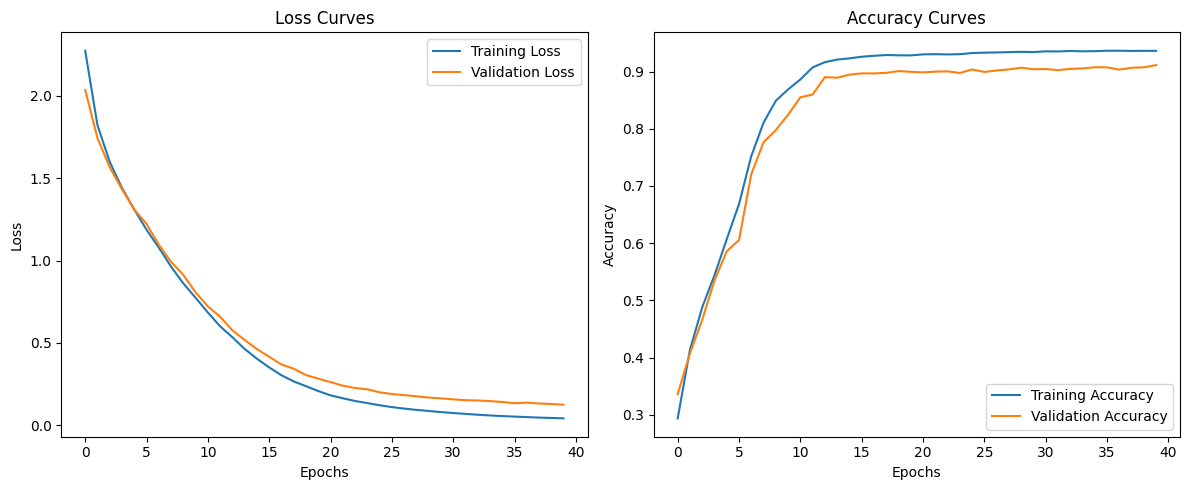

In [ ]:
# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}")

    # Training the model
    running_loss, running_accuracy = train_model(model, train_data_seq, train_data_token, batch_size, num_labels_token_classification)
    train_losses.append(running_loss)
    train_accuracies.append(running_accuracy)

    print(f"Epoch {epoch+1} Average Loss: {running_loss:.4f}, Average Accuracy: {running_accuracy:.4f}")

    # Validating the model
    val_loss, val_accuracy = validate_model(model, test_data_seq, test_data_token, batch_size, num_labels_token_classification)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Validation - Epoch: {epoch+1}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [ ]:
# Define the file path (change 'My Drive/...' to your desired path)
file_path = '/content/drive/MyDrive/training_results_27_12_23.txt'

# Write the data to the file
with open(file_path, 'w') as file:
    file.write('Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy\n')
    for epoch in range(num_epochs):
        file.write(f'{epoch+1},{train_losses[epoch]},{train_accuracies[epoch]},{val_losses[epoch]},{val_accuracies[epoch]}\n')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_dict_27_12_23.pth')



In [ ]:
from seqeval.metrics import classification_report

def test_model(model, sequence_classification_data, token_classification_data, batch_size, num_labels_token_classification):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():  # Disable gradient computation during validation
        for batch in generate_balanced_batches(sequence_classification_data, token_classification_data, batch_size):
            task_name = batch["task_name"][0]
            print("task name",task_name)
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            logits = model(input_ids=input_ids, attention_mask=attention_mask, task_name=task_name)

            if task_name == "sequence_classification":
                labels = batch["sequence_classification_labels"]
                loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fn(logits, labels)

                # Compute accuracy for sequence classification
                preds = torch.argmax(logits, dim=1)

                print("labels")
                print(labels)
                print("preds")
                print(preds)

                eval_labels.extend(labels)
                eval_preds.extend(preds)

                acc = accuracy_score(labels.cpu(), preds.cpu())


            else:  # token_classification
                labels = batch["token_classification_labels"]
                loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, num_labels_token_classification)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fn(active_logits, active_labels)

                # Compute accuracy for token classification
                preds = torch.argmax(active_logits, dim=1)
                #print(" I-----I m hereeeeeeeeeeeeeer")
                #print(active_labels)
                #print(" II----I m hereeeeeeeeeeeeeer")
                #print(preds)
                mask = active_labels != -100
                filtred_labels = active_labels[mask]
                filtred_preds = preds[mask]

                #print(" III----I m hereeeeeeeeeeeeeer")
                #print(filtred_labels)
                #print(" IV----I m hereeeeeeeeeeeeeer")
                #print(filtred_preds)

                acc = accuracy_score(active_labels.cpu(), preds.cpu())

                eval_labels.extend(filtred_labels)
                eval_preds.extend(filtred_preds)

            total_loss += loss.item()
            total_accuracy += acc
            num_batches += 1

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    labels = ["_"+str(id.item()) for id in eval_labels]
    predictions = ["_"+str(id.item()) for id in eval_preds]

    print("##############")
    print(labels)
    print(predictions)


    return avg_loss, avg_accuracy, labels, predictions

In [ ]:
avg_loss, avg_accuracy, labels, predictions = test_model(model, test_data_seq, test_data_token, batch_size, num_labels_token_classification)
print(classification_report([labels], [predictions]))
print(avg_loss, avg_accuracy)


task name sequence_classification
labels
tensor([ 7,  1,  0,  0,  9, 10, 14, 14,  8,  9,  8, 10,  8, 16,  9,  9, 14,  2,
         2,  0, 14, 12,  8,  8,  8,  7, 15, 13, 16,  7, 13, 13,  2, 15, 16, 10,
        14,  1, 10, 13,  1, 14, 13, 15, 15,  1,  7, 15, 10,  1,  8, 16,  1,  0,
         1,  0, 16,  8, 10, 14, 16, 14,  1,  8, 14,  0,  9,  1, 13,  0,  0, 10,
        10,  2,  8, 13, 14,  1, 14, 15, 14, 12,  1, 10, 16,  1,  2, 13, 10,  2,
         8, 15,  9,  0, 15, 16, 14, 15, 15,  1,  0, 12,  2, 10, 15, 14, 10, 10,
        10,  8,  1, 16, 16,  9,  9,  9,  1, 10, 16,  8, 10,  0, 16, 12, 13, 14,
        14,  0])
preds
tensor([ 7,  1,  0,  0,  9, 10, 14, 14,  8,  9,  8, 10,  9, 16,  9,  9, 14,  2,
         2,  0, 14, 12,  8,  8,  8,  8, 15, 13, 16,  7, 13, 13,  2, 15, 16, 10,
        14,  1, 10, 13,  1, 14, 13, 15, 15,  1,  7, 15, 10,  1,  8, 15,  1,  0,
         1,  0, 16,  8, 10, 14, 16, 14,  1,  8, 14,  0,  9,  9, 13,  0,  0, 10,
        10,  2,  8, 13, 14,  1, 14, 15, 14, 12,  1, 10, 

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _7 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _9 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _10 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWar

In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def bert_find_c(tokenizer, model, sentence, maxlen, num_labels_token_classification):
    model.eval()
    constraint= {}
    #remove ponctuation:
    sentence = re.sub(r'[^\w\s]', '', sentence)
    print(sentence)
    inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=maxlen, return_tensors="pt")
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]

    # get relation
    task_name="sequence_classification"
    outputs = model(ids, mask, task_name)
    logits = outputs[0]
    pred = torch.argmax(logits)

    constraint['rel']=pred.item()

    # get parameters
    task_name="token_classification"
    outputs = model(ids, mask, task_name)
    logits = outputs[0]
    active_logits = logits.view(-1, num_labels_token_classification) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level
    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [i for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)
    #print("wp_preds", wp_preds)
    word_level_predictions = []
    # we will remove cls, sep and pad
    for pair in wp_preds:
      if (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
        continue
      else:
        word_level_predictions.append(pair)

    print("word_level_predictions", word_level_predictions)
    list_params= {pair[1] for pair in word_level_predictions if pair[1]!=0}
    print("list params", list_params)


    for i in list_params:
      p= [pair[0] for pair in word_level_predictions if pair[1]==i]
      param = ''.join(s.replace('##', '') for s in p)
      constraint[i]=param

    return constraint




In [ ]:
"""
dict_constraints={
    0: {"constraint": "all_diff", "template":"templates_all_diff", "n_params":10},
    1: {"constraint": "p1<p2", "template":"templates_param1_strictely_lt_param2", "n_params":2},
    2: {"constraint": "p1>p2", "template":"templates_param1_strictely_gt_param2", "n_params":2},
    3: {"constraint": "|p1-p2|!=p3", "template":"abs_val_param1_minus_param_2_diff_param3", "n_params":3},
    4: {"constraint": "|p1-p2|=|p3-p4|", "template":"abs_val_p1_minus_p2_equal_abs_val_p3_minus_p4", "n_params":4},
    5: {"constraint": "|p1-p2|=p3", "template":"abs_val_p1_minus_p2_equal_p_3", "n_params":3},
    6: {"constraint": "p1+p2 != p3", "template":"templates_sum_x1_x2_diff_x3", "n_params":3},
    7: {"constraint": "p1=p2", "template":"templates_equal_constraint", "n_params":2},
    8: {"constraint": "p1!=p2", "template":"templates_different_than", "n_params":2},
    9: {"constraint": "p1<=p2", "template":"templates_less_than", "n_params":2},
    10: {"constraint": "p1 >= p2", "template":"templates_greater_than", "n_params":2},
    11: {"constraint": "|p1-p2|!=|p3-p4|", "template":"abs_val_p1_minus_p2_diff_abs_val_p3_minus_p4", "n_params":4},
    12: {"constraint": "sum", "template":"sum_params_equal_param", "n_params":10}
}
"""

sentence = "The gap between X2 and X0  equals to 4."
sentence = "Emphasize the significance of distinct values within X33 X70 X100 X16 X37 X15 X36"
#sentence= "Ensure that the measure of distance between X0 and X1 is the same as between X2 and X3"
#sentence="The gap from X0 to X2 should not be identical to the gap from X3 to X4."
sentence= "The total sum of X0 X2 X3 X4 needs to be precisely 0"
sentence = "Enjoin X0  X2  X3 X4 from sharing any values."

#sentence = "Demand the absence of repetitions in X29, X55, X17, X45, X36, X60, X73 X68"
#sentence = "Indicate the necessity of X3 X48 X8 X96 X12 X41 not sharing values"
#sentence="No matching values allowed among X70 X36 X80 X65"
#sentence ="Continuously ensure that |X71 minus X18| is equivalent to |X60 minus X73|"
#sentence ="The distance of X5 from X8 is the same as the distance of X11 from X12"
#sentence= "Ensure that the measure of distance between X0 and X1 is the same as between X2 and X3"


constraint= bert_find_c(tokenizer, model, sentence, maxlen, num_labels_token_classification)
print(constraint)

Enjoin X0  X2  X3 X4 from sharing any values
word_level_predictions [('en', 0), ('##jo', 0), ('##in', 0), ('x', 1), ('##0', 1), ('x', 2), ('##2', 2), ('x', 3), ('##3', 3), ('x', 4), ('##4', 4), ('from', 0), ('sharing', 0), ('any', 0), ('values', 0)]
list params {1, 2, 3, 4}
{'rel': 0, 1: 'x0', 2: 'x2', 3: 'x3', 4: 'x4'}


**Evaluation Mode:** Always remember to set the model to evaluation mode using model.eval() before making predictions, especially when your model uses layers like dropout or batch normalization which have different behavior during training vs testing.

**Device Management:** Ensure the model and data are on the same device (CPU or GPU). If you trained your model on a GPU and are loading it on a machine without a GPU, you can map the storage to CPU.

model.load_state_dict(torch.load('path_to_save_model_state_dict.pth', map_location=torch.device('cpu')))
